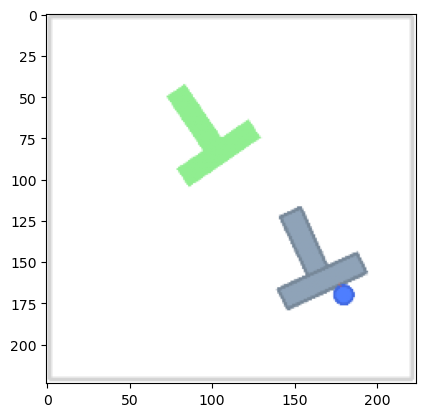

In [2]:
import zarr
import matplotlib.pyplot as plt
from transformers.models.deprecated.transfo_xl.modeling_transfo_xl import PositionalEmbedding

from robotics.model_src.diffusion_model import SinusoidalPositionalEmbedding

dataset = zarr.open("../data/demonstrations_snapshot_1.zarr", mode="r")

image = dataset["data"]["img"][33:37] # [224, 224, 3] with values in range [0-255]

plt.imshow(image[0]/ 255)

## Network


## Visual encoder design

### Abstraction layer

The code defines a `VisualEncoderBase` interface with four compulsory methods—`load_model`, `preprocess`, `encode`, and `get_output_shape`—plus a simple `to` helper that moves everything to the required device. This thin wrapper isolates the policy from any specific vision backbone, so swapping architectures never touches downstream diffusion or FiLM code. The interface also enforces consistent batching and precision handling across all visual variants.

### Transformer baseline

`CLIPVisualEncoder` instantiates the interface with a ViT-B/32 backbone from CLIP. Pre-processing follows the official CLIP recipe (resize, center-crop, normalize to ±1) and the forward pass returns a 512-dimensional, L2-normalized embedding via `get_image_features`. Running the model in `eval()` freezes all weights by default, but the design still lets you un-freeze selective layers for fine-tuning experiments. The transformer path is expected to capture high-level semantics that may improve generalisation to cluttered real-world scenes.

### CNN alternative

A second implementation, tentatively named `CNNVisualEncoder`, will plug a lightweight convolutional backbone such as ResNet-34 or EfficientNet-B0 into the same interface. After the global-average-pool, a small linear head projects to the same 512-D space used by CLIP, keeping the rest of the pipeline unchanged. A CNN offers lower latency, stronger inductive bias for limited data, and better compatibility with edge devices or real-time control loops.

### Evaluation rationale

Both encoders will be dropped into the diffusion policy unchanged, letting us measure three aspects: sample efficiency during fine-tuning, robustness to sim-to-real shifts, and pure throughput in frames per second. The plan is to keep only the best-performing backbone as the default, while retaining the common interface so future backbones remain one import away.


In [3]:
from abc import ABC, abstractmethod
import torch
from transformers import CLIPModel, CLIPProcessor

class VisualEncoderBase(ABC):
    """
    Abstract base class for visual encoders.
    All custom encoders must inherit from this class and implement the required methods.
    """

    def __init__(self, device="cuda"):
        self.device = device

    @abstractmethod
    def load_model(self):
        """
        Loads the pretrained model.
        """
        pass

    @abstractmethod
    def preprocess(self, image):
        """
        Preprocesses a single image or a batch of images for the encoder.
        Returns a tensor ready to be passed to the model.
        """
        pass

    @abstractmethod
    def encode(self, image_tensor):
        """
        Runs the model on the input tensor and returns the embeddings.
        """
        pass

    @abstractmethod
    def get_output_shape(self):
        """
        Runs the model on the input tensor and returns the embeddings.
        """
        pass

    def to(self, device):
        """
        Moves the model to the specified device.
        """
        self.device = device
        return self


class CLIPVisualEncoder(VisualEncoderBase):
    def __init__(self, model_name="openai/clip-vit-base-patch32", device="cuda"):
        super().__init__(device)
        self.model = None
        self.processor = None
        self.model_name = model_name
        self.load_model()

    def load_model(self):
        self.processor = CLIPProcessor.from_pretrained(self.model_name)
        self.model = CLIPModel.from_pretrained(self.model_name)
        self.model.eval().to(self.device)

    def preprocess(self, image):
        inputs = self.processor(images=image, return_tensors="pt")
        return inputs["pixel_values"].to(self.device)

    def encode(self, image_tensor):
        inputs = self.preprocess(image_tensor)
        with torch.no_grad():
            return self.model.get_image_features(pixel_values=inputs)

    def get_output_shape(self):
        return self.model.config.projection_dim





## Observation aggregator

Not implemented yet


*Purpose:* Collapse the last $K=\texttt{obs\_horizon}$ embeddings $\{e_0,\dots,e_{K-1}\}$ into a fixed-length context $g$.
- *Concat* → $g\in\mathbb{R}^{K d_{\text{img}}}$
- *Average* → $g\in\mathbb{R}^{d_{\text{img}}}$


## Sinusoidal positional embedding
*Purpose:* Encode the diffusion step index $t$ into a vector $p_t\in\mathbb{R}^{d_t}$ with

why we even need this. The idea of positional encodings adds the information about the order of the input embeddings. In our problem this is essential part of the noise prediction model design, since the main model should know which step it is now (how much noise will be added). The positional encoding helps to fix this problem by providing an additional component (in our case, addition will be the choice, since concatenating the vectors sounds more expressive but adds extra computational load). Such positional encoding should have 4 main properties:

1. **uniqueness** (position ≡ value)
2. **determinism** (constructed from a known function — this lets the model learn to exploit structure)
3. **distance awareness** (positional similarity encodes proximity)
4. **generalization** (it should extrapolate to longer sequences than seen during training)

there are multiple approaches — learned embeddings, relative encodings, rotary — but sinusoidal encoding is often enough when the exact structure is not language-sensitive but rather needs stable, general-purpose spatial/temporal indices. in this project we rely on sinusoidal encoding because of its simplicity, efficiency, and ability to generalize without extra parameters.

### Math and intuition

for a given position `pos` and embedding dimension index `i`, the positional encoding is defined as:

$$
PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{\frac{2i}{d}}}\right)
$$

$$
PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{\frac{2i}{d}}}\right)
$$

* `d` is the total embedding dimension.
* every pair of sine and cosine encodes one frequency.
* **low i ⇒ high frequency** (short patterns), **high i ⇒ low frequency** (longer patterns)

### Why 10000?

the `10000^(2i/d)` term ensures that frequencies vary exponentially across dimensions. small `i` results in fast oscillations (fine-grained encoding), while large `i` results in slower changes (coarse-grained encoding). this gives the model a sort of **Fourier basis**, where attention mechanisms can match patterns at different temporal scales.

### Derivatives and learning

a nice side-effect: the derivatives of `sin` and `cos` are bounded, periodic functions. this means the gradients during backprop stay stable over long sequences, avoiding vanishing or exploding gradients — which is useful for deep models and long time horizons.




In [4]:
import torch
from matplotlib import pyplot as plt
from torch import nn


def sinusoidal_pos_emb(
    pos: int | torch.Tensor,
    dim: int,
    base: float = 10000.0,
) -> torch.Tensor:
    """
    Compute a sinusoidal positional embedding for a single position.

    Args:
    pos   : int or 0-D tensor – position index.
    dim   : int – embedding dimension (must be even).
    base  : float – base for the exponential frequency scaling.

    Returns:
    Tensor of shape (dim,) containing the positional embedding.
    """
    pos = torch.as_tensor(pos, dtype=torch.float)        # if pos was int
    if pos.dim() == 0:                                   # scalar → (1,)
        pos = pos.unsqueeze(0)

    # Half of the dimensions will be sine, half cosine
    half_dim = dim // 2

    # Exponent term:  base^{2i/dim}  for i = 0 .. half_dim-1
    exponent = torch.arange(half_dim, dtype=torch.float)
    div_term = base ** (2 * exponent / dim)  # (half_dim,)

    # Compute the value: pos / base^{2i/dim}
    value = pos.unsqueeze(-1) / div_term                    # (num_pos, half_dim)

    emb = torch.empty(pos.size(0), dim, dtype=torch.float)
    emb[:, 0::2] = torch.sin(value)              # even indices  -> sin
    emb[:, 1::2] = torch.cos(value)              # odd  indices -> cos
    return emb


def visualize_encoding(vectors):
    plt.imshow(vectors.permute(1, 0), aspect='auto', cmap='viridis')
    plt.colorbar(label='value')
    plt.ylabel('embedding dimension')
    plt.xlabel('position')
    plt.title('Sinusoidal Embeddings heatmap view')
    plt.tight_layout()
    plt.show()

#### Visualisation

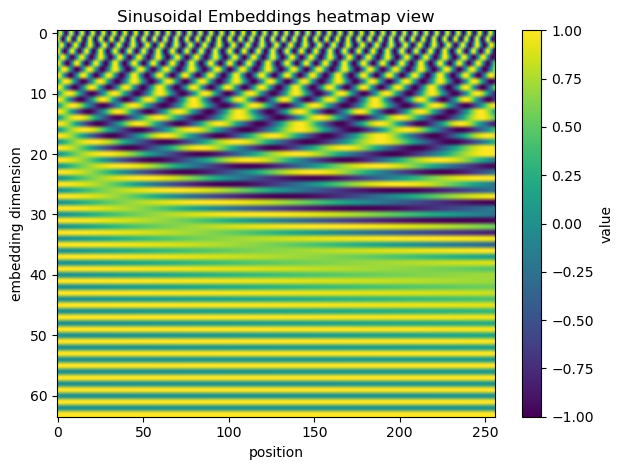

In [4]:
positions = torch.arange(256)

embeddings = sinusoidal_pos_emb(positions, 64)

visualize_encoding(embeddings)

## Downsample1D
Halves the sequence length with a single 1-D convolution (kernel = 3, stride = 2).


**12. Reverse-process scheduler**
Uses $(a_t,\hat\varepsilon,t)$ to compute $a_{t-1}$ under a chosen DDPM or DDIM rule.

**13. Loss**

$$
\mathcal{L}=\mathbb{E}\bigl[\;\|\varepsilon-\hat\varepsilon_\theta(a_t,t,\phi(o))\|^2\bigr],
$$

optimising image encoder, FiLM projections and all convolutional weights.

---

## One training / inference step

1. Collect the last $K$ frames, encode each with the visual encoder, aggregate to get $g$.
2. Encode the current diffusion step: $t \rightarrow p_t$.
3. Build the global condition $\text{cond}=[p_t;g]$.
4. Feed the noisy action sequence $a_t$ (reshaped to $(B,2,T)$) through the Conditional U-Net; FiLM layers inject **cond** at every scale.
5. The U-Net outputs $\hat\varepsilon$:

   * **Training:** compute the loss above and update parameters.
   * **Inference:** the scheduler moves $a_t \mapsto a_{t-1}$; repeat until $a_0$ (the clean action trajectory) is produced.

Visual information thus modulates every layer via FiLM, the time embedding tells the network how much noise to remove, and the 1-D convolutional U-Net learns a coherent action sequence of length $\texttt{pred\_horizon}$ conditioned on the observations.


## Unet

In [5]:
from typing import Union


class Downsample1D(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv1d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)

class Upsample1D(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.ConvTranspose1d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)


class Conv1DBlock(nn.Module):
    def __init__(self, in_channels, out_channels, ker_size):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, ker_size, padding=ker_size//2),
            nn.BatchNorm1d(out_channels),
            nn.Mish(),
        )

    def forward(self, x):
        return self.block(x)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, cond_dim, ker_size):
        super().__init__()

        self.modules = nn.ModuleList([
            Conv1DBlock(in_channels, out_channels, ker_size),
            Conv1DBlock(out_channels, out_channels, ker_size),
        ])

        cond_channels = out_channels * 2
        self.out_channels = out_channels
        self.cond_encoder = nn.Sequential(
            nn.Mish(),
            nn.Linear(cond_dim, cond_channels),
            nn.Unflatten(-1, (-1, 1))
        )

        self.residual_conv = nn.Conv1d(in_channels, out_channels, 1) \
            if in_channels != out_channels else nn.Identity()

    def forward(self, x, condition):
        first_out = self.modules[0](x)

        embedded_condition = self.cond_encoder(condition) # [B, 2 * C_out, 1]

        embedded_condition = embedded_condition.reshape(embedded_condition.shape[0],
                                                      2,
                                                      self.out_channels,
                                                      1)
        scale = embedded_condition[:, 0, ...]
        bias = embedded_condition[:, 1, ...]

        # apply FILM

        out = first_out * scale + bias

        second_out = self.modules[1](out)

        out = second_out + self.residual_conv(x)

        return out

class ConditionalUnet1D(nn.Module):
    def __init__(self,
        input_dim,
        global_cond_dim,
        diffusion_step_embed_dim=256,
        down_dims=[256,512,1024],
        kernel_size=5,
        n_groups=8
        ):
        """
        input_dim: Dim of actions.
        global_cond_dim: Dim of global conditioning applied with FiLM
          in addition to diffusion step embedding. This is usually obs_horizon * obs_dim
        diffusion_step_embed_dim: Size of positional encoding for diffusion iteration k
        down_dims: Channel size for each UNet level.
          The length of this array determines numebr of levels.
        kernel_size: Conv kernel size
        n_groups: Number of groups for GroupNorm
        """

        super().__init__()
        all_dims = [input_dim] + list(down_dims)
        start_dim = down_dims[0]

        dsed = diffusion_step_embed_dim
        diffusion_step_encoder = nn.Sequential(
            SinusoidalPositionalEmbedding(dsed),
            nn.Linear(dsed, dsed * 4),
            nn.Mish(),
            nn.Linear(dsed * 4, dsed),
        )
        cond_dim = dsed + global_cond_dim

        in_out = list(zip(all_dims[:-1], all_dims[1:]))
        mid_dim = all_dims[-1]
        self.mid_modules = nn.ModuleList([
            ResidualBlock(
                mid_dim, mid_dim, cond_dim=cond_dim,
                ker_size=kernel_size
            ),
            ResidualBlock(
                mid_dim, mid_dim, cond_dim=cond_dim,
                ker_size=kernel_size
            ),
        ])

        down_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (len(in_out) - 1)
            down_modules.append(nn.ModuleList([
                ResidualBlock(
                    dim_in, dim_out, cond_dim=cond_dim,
                    ker_size=kernel_size),
                ResidualBlock(
                    dim_out, dim_out, cond_dim=cond_dim,
                    ker_size=kernel_size),
                Downsample1D(dim_out) if not is_last else nn.Identity()
            ]))

        up_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (len(in_out) - 1)
            up_modules.append(nn.ModuleList([
                ResidualBlock(
                    dim_out*2, dim_in, cond_dim=cond_dim,
                    ker_size=kernel_size),
                ResidualBlock(
                    dim_in, dim_in, cond_dim=cond_dim,
                    ker_size=kernel_size),
                Upsample1D(dim_in) if not is_last else nn.Identity()
            ]))

        final_conv = nn.Sequential(
            Conv1DBlock(start_dim, start_dim, ker_size=kernel_size),
            nn.Conv1d(start_dim, input_dim, 1),
        )

        self.diffusion_step_encoder = diffusion_step_encoder
        self.up_modules = up_modules
        self.down_modules = down_modules
        self.final_conv = final_conv

        print("number of parameters: {:e}".format(
            sum(p.numel() for p in self.parameters()))
        )

    def forward(self,
            sample: torch.Tensor,
            timestep: Union[torch.Tensor, float, int],
            global_cond=None):
        """
        x: (B,T,input_dim)
        timestep: (B,) or int, diffusion step
        global_cond: (B,global_cond_dim)
        output: (B,T,input_dim)
        """
        # (B,T,C)
        sample = sample.moveaxis(-1,-2)
        # (B,C,T)

        # 1. time
        timesteps = timestep
        if not torch.is_tensor(timesteps):
            timesteps = torch.tensor([timesteps], dtype=torch.long, device=sample.device)
        elif torch.is_tensor(timesteps) and len(timesteps.shape) == 0:
            timesteps = timesteps[None].to(sample.device)
        # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
        timesteps = timesteps.expand(sample.shape[0])

        global_feature = self.diffusion_step_encoder(timesteps)

        if global_cond is not None:
            global_feature = torch.cat([
                global_feature, global_cond
            ], axis=-1)

        x = sample
        h = []
        for idx, (resnet, resnet2, downsample) in enumerate(self.down_modules):
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            h.append(x)
            x = downsample(x)

        for mid_module in self.mid_modules:
            x = mid_module(x, global_feature)

        for idx, (resnet, resnet2, upsample) in enumerate(self.up_modules):
            x = torch.cat((x, h.pop()), dim=1)
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            x = upsample(x)

        x = self.final_conv(x)

        # (B,C,T)
        x = x.moveaxis(-1,-2)
        # (B,T,C)
        return x